## Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import seaborn as sns
import scipy
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
from datetime import datetime
import pickle
import time
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

In [2]:
drive.mount('/content/drive/')

trainingSet = pd.read_csv("/content/drive/My Drive/Fourth CS506 Midterm/train.csv")
testingSet = pd.read_csv("/content/drive/My Drive/Fourth CS506 Midterm/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

# trainingSet['is_fraud'].value_counts().plot(kind='bar', legend=True, alpha=.5)
# plt.title("Count of Fraud")
# plt.show()

Mounted at /content/drive/
train.csv shape is  (555719, 23)
test.csv shape is  (69465, 2)


## Feature Extraction

In [3]:
#Calculate the great circle distance in kilometers between two points
#on the earth (specified in decimal degrees)
def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [4]:
def process(df):
    # This is where you can do all your processing
    date_time = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

    df['trans_date'] = date_time.dt.date
    df['trans_time'] = date_time.dt.time
    # df.drop(columns='trans_date_trans_time', inplace=True)

    return df

# Load the dataset
trainingSet = pd.read_csv("/content/drive/My Drive/Fourth CS506 Midterm/train.csv")
# Load test set
submissionSet = pd.read_csv("/content/drive/My Drive/Fourth CS506 Midterm/test.csv")

print("trainingSet shape is ", trainingSet.shape)
print("submissionSet shape is ", submissionSet.shape)

trainingSet shape is  (555719, 23)
submissionSet shape is  (69465, 2)


In [5]:
# # Process the DataFrame
# train_processed = process(trainingSet) #run once
# # train_processed = trainingSet

date_time = pd.to_datetime(trainingSet['trans_date_trans_time'], format='%d/%m/%Y %H:%M')

trainingSet['trans_date'] = date_time.dt.date
trainingSet['trans_time'] = date_time.dt.time

In [6]:
import holidays

# Convert 'trans_date' to datetime
trainingSet['trans_date'] = pd.to_datetime(trainingSet['trans_date'])

# Then apply your function to check for holidays
us_holidays = holidays.UnitedStates()
trainingSet['is_holiday'] = trainingSet['trans_date'].dt.date.apply(lambda x: x in us_holidays)

In [7]:
# Average Transaction Amount per Customer
customer_avg_amt = trainingSet.groupby('cc_num')['amt'].transform('mean')
trainingSet['customer_avg_amt'] = customer_avg_amt

# Frequency of Transactions per Customer (per day as an example)
trainingSet['date'] = trainingSet['trans_date'].dt.date
customer_daily_freq = trainingSet.groupby(['cc_num', 'date'])['amt'].transform('count')
trainingSet['customer_daily_freq'] = customer_daily_freq

# Historical Fraud Rate per Customer
# Assuming is_fraud is 0 for non-fraud and 1 for fraud
customer_fraud_rate = trainingSet.groupby('cc_num')['is_fraud'].transform('mean')
trainingSet['customer_fraud_rate'] = customer_fraud_rate

In [8]:
# Same Merchant Previous Fraud
# This feature requires historical data of fraud per merchant
merchant_fraud_history = trainingSet.groupby('merchant')['is_fraud'].transform('max')
trainingSet['merchant_fraud_history'] = merchant_fraud_history

# New Merchant Indicator - date
# This indicates if this is the first transaction with a merchant for a customer
trainingSet.sort_values(by=['cc_num', 'trans_date'], inplace=True)
trainingSet['first_trans_with_merchant_date'] = trainingSet.groupby(['cc_num', 'merchant']).cumcount() == 0

# New Merchant Indicator - time
# This indicates if this is the first transaction with a merchant for a customer
trainingSet.sort_values(by=['cc_num', 'trans_time'], inplace=True)
trainingSet['first_trans_with_merchant_time'] = trainingSet.groupby(['cc_num', 'merchant']).cumcount() == 0

# Category-specific Average Amount
category_avg_amt = trainingSet.groupby('category')['amt'].transform('mean')
trainingSet['category_avg_deviation'] = trainingSet['amt'] - category_avg_amt

In [9]:
trainingSet['distance_to_merchant_km'] = trainingSet.apply(
    lambda row: np.abs(haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long'])),
    axis=1
)

In [10]:
# Convert 'dob' to datetime
trainingSet['dob'] = pd.to_datetime(trainingSet['dob'], format='%d/%m/%Y')

# Calculate age
current_time = datetime.now()
trainingSet['age'] = trainingSet['dob'].apply(lambda x: current_time.year - x.year - ((current_time.month, current_time.day) < (x.month, x.day)))

# print(trainingSet['age'])

#Additional Feature Eng

In [11]:
# train_processed = process(trainingSet)
date_time = pd.to_datetime(trainingSet['trans_date_trans_time'], format='%d/%m/%Y %H:%M')
trainingSet['trans_date'] = date_time.dt.date
trainingSet['trans_time'] = date_time.dt.time
# print(trainingSet['trans_date'].unique())
# trainingSet.drop(columns='trans_date_trans_time', inplace=True)

In [12]:
trainingSet['trans_date'] = pd.to_datetime(trainingSet['trans_date'])
# print(trainingSet['trans_date'].unique())
trainingSet['day_of_week'] = trainingSet['trans_date'].dt.day_name()
trainingSet['day_of_week'].unique()

array(['Wednesday', 'Saturday', 'Friday', 'Monday', 'Tuesday', 'Sunday',
       'Thursday'], dtype=object)

In [15]:
trainingSet['trans_month'] = date_time.dt.month
months = { 1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
trainingSet['month_name'] = trainingSet['trans_month'].map(months)
trainingSet['trans_year'] = date_time.dt.year
trainingSet['hour_of_day'] = date_time.dt.hour

In [16]:
trainingSet['age_at_transaction'] = trainingSet['trans_year'] - trainingSet['dob'].dt.year

In [18]:
categories = ['shopping_net', 'grocery_pos', 'misc_net', 'shopping_pos']
for cat in categories:
    trainingSet[f'is_{cat}'] = (trainingSet['category'] == cat).astype(int)

In [19]:
# Average spending per category
average_spending_per_category = trainingSet.groupby('category')['amt'].mean()
trainingSet['above_avg_spend'] = trainingSet.apply(lambda row: row['amt'] > average_spending_per_category.loc[row['category']], axis=1).astype(int)

# Correct handling for fraudulent transactions
fraud_transactions = trainingSet[trainingSet['is_fraud'] == 1]
avg_fraud_spend_per_category = fraud_transactions.groupby('category')['amt'].mean().reset_index().rename(columns={'amt': 'avg_fraud_amt'})

# Merge average spending data
trainingSet = pd.merge(trainingSet, average_spending_per_category.reset_index().rename(columns={'amt': 'avg_non_fraud_amt'}), on='category', how='left')
trainingSet = pd.merge(trainingSet, avg_fraud_spend_per_category, on='category', how='left')

trainingSet['avg_fraud_amt'] = trainingSet['avg_fraud_amt'].fillna(0)

In [21]:
# Unusual spending threshold
threshold_multiplier = 1.2
trainingSet['unusual_spending'] = (trainingSet['amt'] > (trainingSet['avg_non_fraud_amt'] * threshold_multiplier)).astype(int)

# Transaction frequency per user
transaction_freq = trainingSet.groupby('cc_num')['trans_date_trans_time'].count()
trainingSet['transaction_frequency'] = trainingSet['cc_num'].map(transaction_freq)
trainingSet['freq_bin'] = pd.cut(trainingSet['transaction_frequency'], bins=[0, 2, 8, 16, trainingSet['transaction_frequency'].max()], labels=False)

In [22]:
high_risk_merchants = ['fraud_Rodriguez, Yost and Jenkins'
        'fraud_Mosciski, Ziemann and Farrell'
        'fraud_Heathcote LLC'
        'fraud_Heathcote, Yost and Kertzmann'
        'fraud_Lemke-Gutmann'
        'fraud_Mante Group'
        'fraud_Romaguera, Cruickshank and Greenholt'
        'fraud_Bednar Group'
        'fraud_Bashirian Group'
        'fraud_Klocko LLC']

# Create a new column 'is_high_risk_merchant' which is 1 if the merchant is in the high-risk list, else 0
trainingSet['is_high_risk_merchant'] = trainingSet['merchant'].apply(lambda x: 1 if x in high_risk_merchants else 0)

# Feature for high-risk hours
trainingSet['high_risk_hour'] = trainingSet['hour_of_day'].apply(lambda x: 1 if x in [22, 23, 0, 1, 2, 3] else 0)

# Feature for high-risk category during high-risk hours (22-23 for shopping_net)
trainingSet['high_risk_hour_shopping_net'] = ((trainingSet['hour_of_day'].isin([22, 23])) & (trainingSet['category'] == 'shopping_net')).astype(int)

# Feature for high-risk category during high-risk hours (0-3 for grocery_pos)
trainingSet['high_risk_hour_grocery_pos'] = ((trainingSet['hour_of_day'].isin([0, 1, 2, 3])) & (trainingSet['category'] == 'grocery_pos')).astype(int)

#Data merch_long and merch_lat

In [23]:
!pip install kmodes

In [24]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [25]:
# Assuming trainingSet_Categorical is your DataFrame and contains the columns in numerical format to be scaled
categorical_owner_lat_long= ['lat', 'long']

# # Initialize MinMaxScaler
# scaler = MinMaxScaler()

# # Create a copy of the DataFrame to store scaled values
df_scaled_owner_lat_long = trainingSet.copy()

# Scale only the specified columns and replace them in the copy
# df_scaled_owner_lat_long[categorical_owner_lat_long] = scaler.fit_transform(trainingSet[categorical_owner_lat_long])
df_scaled_owner_lat_long[categorical_owner_lat_long] = trainingSet[categorical_owner_lat_long]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


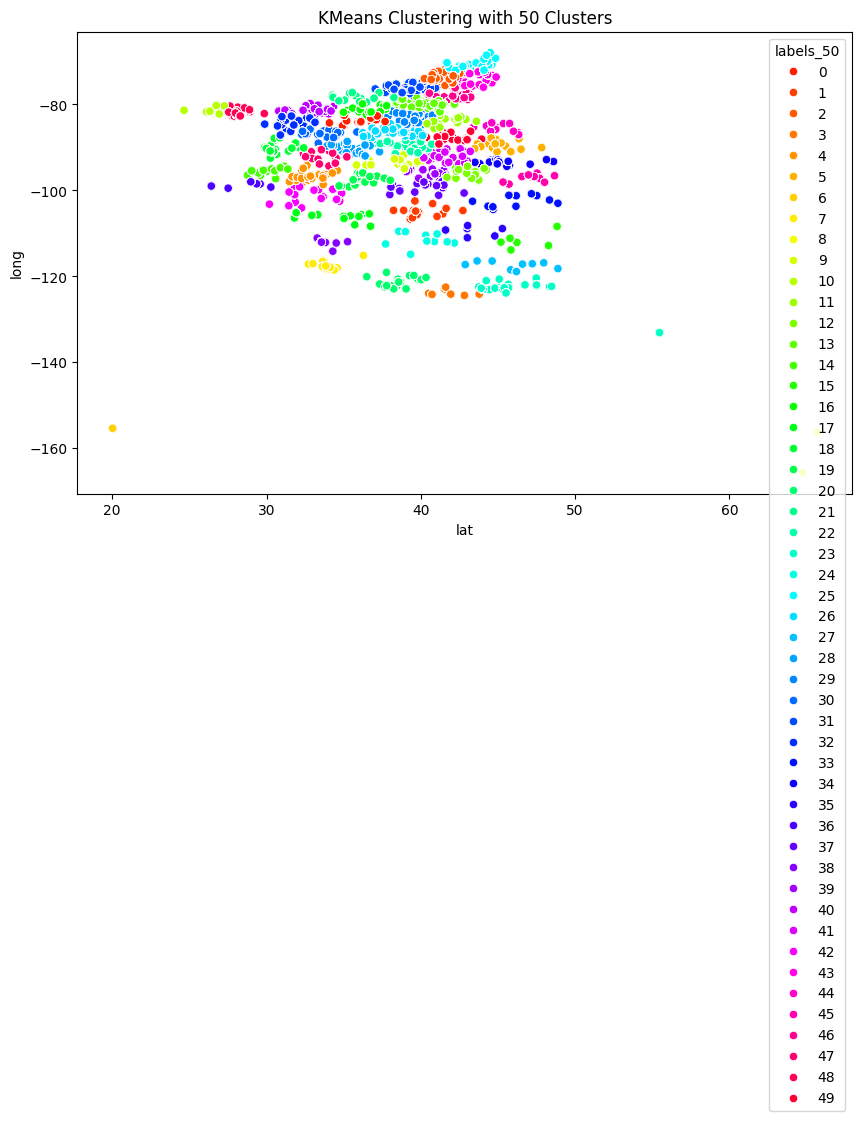

In [26]:
# List of cluster sizes you want to try
# [15,20,30]
cluster_sizes = [50]

# Assuming df_scaled_owner_lat_long is your DataFrame and is already defined and scaled appropriately
# Assuming 'lat' and 'long' are the names of your latitude and longitude columns in df_scaled_owner_lat_long

for n_clusters in cluster_sizes:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Assuming 'categorical_owner_lat_long' is a list of column names to be used for clustering
    # Fit KMeans
    kmeans.fit(df_scaled_owner_lat_long[categorical_owner_lat_long])

    # Assign the cluster labels to a new column in the DataFrame
    df_scaled_owner_lat_long[f'labels_{n_clusters}'] = kmeans.labels_

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_scaled_owner_lat_long, x='lat', y='long', hue=f'labels_{n_clusters}', palette=sns.color_palette("hsv", n_clusters))
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')
    plt.show()

In [27]:
# Assuming trainingSet_Categorical is your DataFrame and contains the columns in numerical format to be scaled
categorical_owner_merch_lat_long= ['merch_lat', 'merch_long']

# # Initialize MinMaxScaler
# scaler = MinMaxScaler()

# Create a copy of the DataFrame to store scaled values
df_scaled_merch_lat_long = trainingSet.copy()

# Scale only the specified columns and replace them in the copy
# df_scaled_merch_lat_long[categorical_owner_merch_lat_long] = scaler.fit_transform(trainingSet[categorical_owner_merch_lat_long])
df_scaled_merch_lat_long[categorical_owner_merch_lat_long] = trainingSet[categorical_owner_merch_lat_long]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


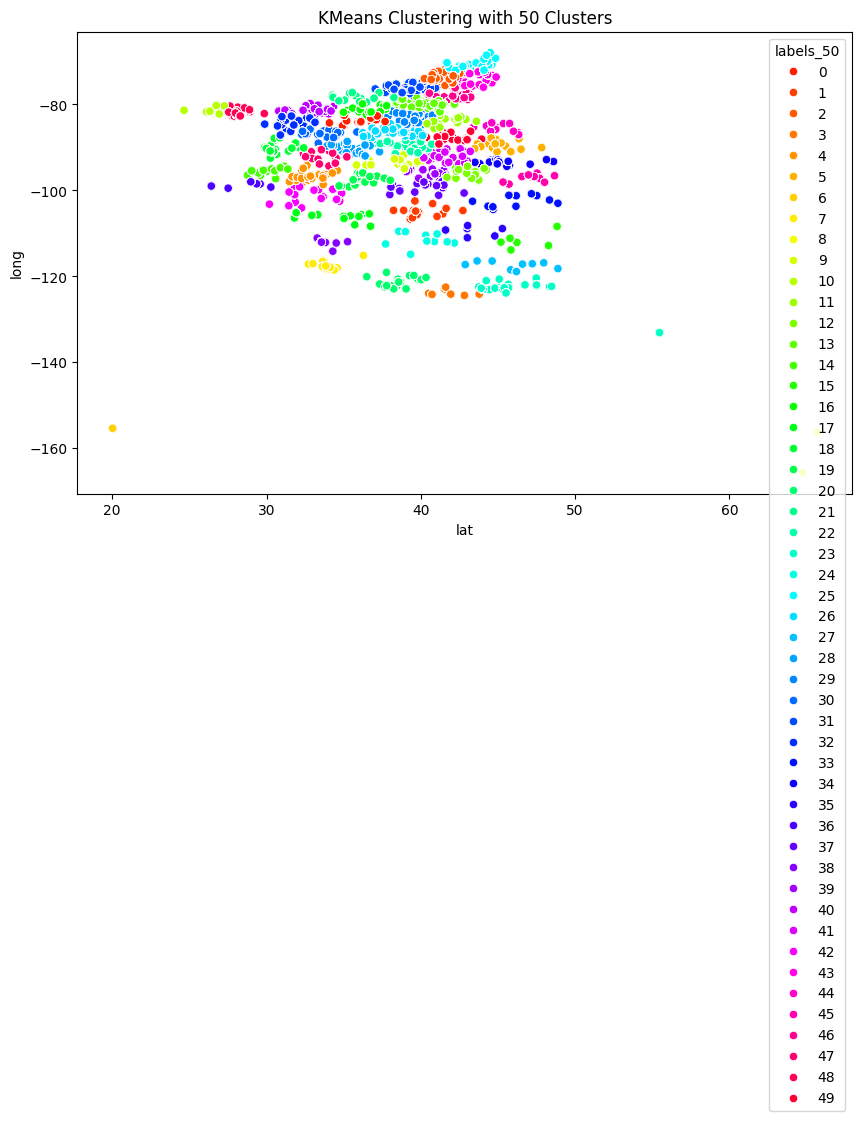

In [28]:
cluster_sizes = [50]

# Assuming df_scaled_owner_lat_long is your DataFrame and is already defined and scaled appropriately
# Assuming 'lat' and 'long' are the names of your latitude and longitude columns in df_scaled_owner_lat_long

for n_clusters in cluster_sizes:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Assuming 'categorical_owner_lat_long' is a list of column names to be used for clustering
    # Fit KMeans
    kmeans.fit(df_scaled_merch_lat_long[categorical_owner_merch_lat_long])

    # Assign the cluster labels to a new column in the DataFrame
    df_scaled_merch_lat_long[f'labels_{n_clusters}'] = kmeans.labels_

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_scaled_owner_lat_long, x='lat', y='long', hue=f'labels_{n_clusters}', palette=sns.color_palette("hsv", n_clusters))
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')
    plt.show()

In [30]:
# Make a copy of trainingSet_Numerical to preserve the original data
trainingSet_cluster_copy = trainingSet.copy()

# Then, add the cluster labels to this new DataFrame
trainingSet_cluster_copy['labels_owner'] = df_scaled_owner_lat_long['labels_50']
trainingSet_cluster_copy['labels_merch'] = df_scaled_merch_lat_long['labels_50']  # Assuming df_scaled_merch_lat_long is already defined
categorical_owner_merch_lat_long= ['labels_owner', 'labels_merch']
trainingSet_cluster_copy.drop([col for col in trainingSet_cluster_copy.columns if col not in categorical_owner_merch_lat_long], axis=1, inplace=True)
trainingSet['cluster_owner'] = trainingSet_cluster_copy['labels_owner']
trainingSet['cluster_merch'] =trainingSet_cluster_copy['labels_merch']

In [34]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 58 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   Id                              555719 non-null  int64         
 1   trans_date_trans_time           555719 non-null  object        
 2   cc_num                          555719 non-null  float64       
 3   merchant                        555719 non-null  object        
 4   category                        555719 non-null  object        
 5   amt                             555719 non-null  float64       
 6   first                           555719 non-null  object        
 7   last                            555719 non-null  object        
 8   gender                          555719 non-null  object        
 9   street                          555719 non-null  object        
 10  city                            555719 non-null  object 

#Check significance

In [32]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'train_processed' is your DataFrame and it's already loaded

# Drop rows where 'is_fraud' is NaN to ensure the statistical tests can run
train_processed_clean = trainingSet.dropna(subset=['is_fraud'])

# Convert 'is_fraud' to an integer type if it's not already, to facilitate comparisons
train_processed_clean['is_fraud'] = train_processed_clean['is_fraud'].astype(int)

# List of features to exclude from the analysis (e.g., identifiers, datetime)
exclude_features = ['Id', 'dob', 'trans_date', 'trans_time', 'date']

# Separating features into numerical and categorical based on dtype (excluding some types for simplicity)
numerical_features = train_processed_clean.select_dtypes(include=[np.number]).columns.difference(exclude_features)
categorical_features = train_processed_clean.select_dtypes(exclude=[np.number, 'datetime64[ns]', 'bool']).columns.difference(exclude_features)

# Performing t-tests for numerical features
print("T-Tests for Numerical Features:")
for feature in numerical_features:
    grouped = train_processed_clean.groupby('is_fraud')[feature]
    t_stat, p_val = stats.ttest_ind(grouped.get_group(0), grouped.get_group(1), nan_policy='omit')
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{feature}: T-statistic = {t_stat:.3f}, P-value = {p_val:.3f} ({significance})")

# Performing chi-squared tests for categorical features
print("\nChi-Squared Tests for Categorical Features:")
for feature in categorical_features:
    contingency_table = pd.crosstab(train_processed_clean[feature], train_processed_clean['is_fraud'])
    chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
    significance = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"{feature}: Chi2-statistic = {chi2_stat:.3f}, P-value = {p_val:.3f} ({significance})")

# Note: For boolean features, you might convert them to integers and perform a chi-squared test or a different analysis as appropriate.


<ipython-input-32-903fbcb9c77a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_processed_clean['is_fraud'] = train_processed_clean['is_fraud'].astype(int)


T-Tests for Numerical Features:
above_avg_spend: T-statistic = -37.968, P-value = 0.000 (Significant)
age: T-statistic = -5.128, P-value = 0.000 (Significant)
age_at_transaction: T-statistic = -5.011, P-value = 0.000 (Significant)
amt: T-statistic = -130.260, P-value = 0.000 (Significant)
avg_fraud_amt: T-statistic = -27.624, P-value = 0.000 (Significant)
avg_non_fraud_amt: T-statistic = -28.875, P-value = 0.000 (Significant)
category_avg_deviation: T-statistic = -127.450, P-value = 0.000 (Significant)
cc_num: T-statistic = 0.563, P-value = 0.573 (Not Significant)
city_pop: T-statistic = 3.236, P-value = 0.001 (Significant)
cluster_merch: T-statistic = -2.309, P-value = 0.021 (Significant)
cluster_owner: T-statistic = 2.180, P-value = 0.029 (Significant)
customer_avg_amt: T-statistic = -128.471, P-value = 0.000 (Significant)
customer_daily_freq: T-statistic = -3.747, P-value = 0.000 (Significant)
customer_fraud_rate: T-statistic = -227.046, P-value = 0.000 (Significant)
distance_to_mer

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


is_high_risk_merchant: T-statistic = nan, P-value = nan (Not Significant)
is_misc_net: T-statistic = -15.847, P-value = 0.000 (Significant)
is_shopping_net: T-statistic = -26.664, P-value = 0.000 (Significant)
is_shopping_pos: T-statistic = -1.197, P-value = 0.231 (Not Significant)
lat: T-statistic = -4.395, P-value = 0.000 (Significant)
long: T-statistic = 1.475, P-value = 0.140 (Not Significant)
merch_lat: T-statistic = -4.354, P-value = 0.000 (Significant)
merch_long: T-statistic = 1.549, P-value = 0.121 (Not Significant)


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


merchant_fraud_history: T-statistic = -23.164, P-value = 0.000 (Significant)
trans_month: T-statistic = 7.924, P-value = 0.000 (Significant)
trans_year: T-statistic = nan, P-value = nan (Not Significant)
transaction_frequency: T-statistic = 27.206, P-value = 0.000 (Significant)
unix_time: T-statistic = 8.814, P-value = 0.000 (Significant)
unusual_spending: T-statistic = -50.421, P-value = 0.000 (Significant)
zip: T-statistic = 0.916, P-value = 0.360 (Not Significant)

Chi-Squared Tests for Categorical Features:
category: Chi2-statistic = 1657.174, P-value = 0.000 (Significant)
city: Chi2-statistic = 39098.521, P-value = 0.000 (Significant)
day_of_week: Chi2-statistic = 119.167, P-value = 0.000 (Significant)
first: Chi2-statistic = 13754.904, P-value = 0.000 (Significant)
gender: Chi2-statistic = 0.187, P-value = 0.666 (Not Significant)
job: Chi2-statistic = 11043.252, P-value = 0.000 (Significant)
last: Chi2-statistic = 18883.917, P-value = 0.000 (Significant)
merchant: Chi2-statistic 

Result from test significance

Result above suggests that features such as amt, age, city_pop, cluster_owner, customer_avg_amt, customer_daily_freq, customer_fraud_rate, lat, merch_lat, merchant_fraud_history, and unix_time could be important predictors for detecting fraud.

Not Significant Variables (P-value ≥ 0.05): Features like cc_num, cluster_merch, distance_to_merchant_km, long, merch_long, and zip do not show a statistically significant difference in means between the two groups.

Significant Variables: Categorical features such as category, city, first, job, last, merchant, state, and street

Not Significant Variables: gender and trans_num

In [37]:
# Assuming 'train_processed' is your DataFrame after initial processing
# and 'submissionSet' is your DataFrame ready for submission/testing

# Combine the lists of significant numerical and categorical features, plus 'Id' and 'is_fraud'
significant_features = [
    'above_avg_spend', 'age', 'age_at_transaction', 'amt', 'avg_fraud_amt',
    'avg_non_fraud_amt', 'category_avg_deviation', 'city_pop', 'cluster_merch',
    'cluster_owner', 'customer_avg_amt', 'customer_daily_freq', 'customer_fraud_rate',
    'freq_bin', 'high_risk_hour', 'high_risk_hour_grocery_pos', 'high_risk_hour_shopping_net',
    'hour_of_day', 'is_fraud', 'is_grocery_pos', 'is_misc_net', 'is_shopping_net',
    'lat', 'merch_lat', 'merchant_fraud_history', 'trans_month', 'transaction_frequency',
    'unix_time', 'unusual_spending',
    'category', 'city', 'day_of_week', 'first', 'job', 'last', 'merchant', 'month_name', 'state', 'street',
    'trans_date_trans_time', 'Id'
]

# Preparing the training dataset by including only significant features and rows where 'is_fraud' is not null
trainX = trainingSet[significant_features]
trainX = trainX[trainX['is_fraud'].notnull()]

# Preparing the testing dataset by including only significant features from 'train_processed'
# Assuming 'Id' is present in both 'submissionSet' and 'train_processed' for correct merging
testX = pd.merge(submissionSet[['Id']], trainingSet[significant_features], on='Id')

print("Train dataset shape (trainX):", trainX.shape)
print("Test dataset shape (testX):", testX.shape)


Train dataset shape (trainX): (486254, 41)
Test dataset shape (testX): (69465, 41)


In [47]:
# # List of significant numerical and categorical variables based on your tests
# significant_numerical = ['age', 'amt', 'category_avg_deviation', 'city_pop', 'cluster_owner',
#                          'customer_avg_amt', 'customer_daily_freq', 'customer_fraud_rate',
#                          'lat', 'merch_lat', 'merchant_fraud_history', 'unix_time']

# significant_categorical = ['category', 'city', 'first', 'job', 'last', 'merchant', 'state', 'street']

# # Combining all significant variables and including 'Id' and 'is_fraud' for merging and labeling
# significant_variables = significant_numerical + significant_categorical + ['Id', 'is_fraud']

# # Update train_processed to only include significant variables before the merge
# train_processed_significant = train_processed[significant_variables]

# # Proceed with your existing steps, using the filtered dataset
# testX = pd.merge(train_processed_significant, submissionSet, on='Id')
# testX = testX.drop(columns=['is_fraud_x'])
# testX = testX.rename(columns={'is_fraud_y': 'is_fraud'})

# # Update trainX to include only significant variables and where 'is_fraud' is not null
# trainX = train_processed_significant[train_processed_significant['is_fraud'].notnull()]

# print("trainingSet shape is ", train_processed_significant.shape)
# print("submissionSet shape is ", submissionSet.shape)


trainingSet shape is  (555719, 22)
submissionSet shape is  (69465, 2)


In [ ]:
# # Merge on Id so that the test set can have feature columns as well
# testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
# testX = testX.drop(columns=['is_fraud_x'])
# testX = testX.rename(columns={'is_fraud_y': 'is_fraud'})

# # The training set is where the score is not null
# trainX =  train_processed[train_processed['is_fraud'].notnull()]

# print("trainingSet shape is ", trainingSet.shape)
# print("submissionSet shape is ", submissionSet.shape)

In [38]:
# Save the datasets with the new features for easy access later
testX.to_csv("/content/drive/My Drive/Fourth CS506 Midterm/X_test.csv", index=False)
trainX.to_csv("/content/drive/My Drive/Fourth CS506 Midterm/X_train.csv", index=False)
print("testX shape is ", testX.shape)
print("testX shape is ", trainX.dtypes)
print("trainX shape is ", trainX.shape)
print("testX shape is ", trainX.head)

testX shape is  (69465, 41)
testX shape is  above_avg_spend                  int64
age                              int64
age_at_transaction               int64
amt                            float64
avg_fraud_amt                  float64
avg_non_fraud_amt              float64
category_avg_deviation         float64
city_pop                         int64
cluster_merch                    int32
cluster_owner                    int32
customer_avg_amt               float64
customer_daily_freq              int64
customer_fraud_rate            float64
freq_bin                         int64
high_risk_hour                   int64
high_risk_hour_grocery_pos       int64
high_risk_hour_shopping_net      int64
hour_of_day                      int64
is_fraud                       float64
is_grocery_pos                   int64
is_misc_net                      int64
is_shopping_net                  int64
lat                            float64
merch_lat                      float64
merchant_fraud_histo

## Creating your model

In [39]:
# Load training set with new features into DataFrame
X_train = pd.read_csv("/content/drive/My Drive/Fourth CS506 Midterm/X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),
        X_train['is_fraud'],
        test_size=1/4.0,
        random_state=0
    )

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(364690, 40)
(121564, 40)
(364690,)
(121564,)


In [40]:
# This is where you can do more feature selection
X_train_processed = X_train._get_numeric_data()
print(X_train_processed.columns)
X_test_processed = X_test._get_numeric_data()


Index(['above_avg_spend', 'age', 'age_at_transaction', 'amt', 'avg_fraud_amt',
       'avg_non_fraud_amt', 'category_avg_deviation', 'city_pop',
       'cluster_merch', 'cluster_owner', 'customer_avg_amt',
       'customer_daily_freq', 'customer_fraud_rate', 'freq_bin',
       'high_risk_hour', 'high_risk_hour_grocery_pos',
       'high_risk_hour_shopping_net', 'hour_of_day', 'is_grocery_pos',
       'is_misc_net', 'is_shopping_net', 'lat', 'merch_lat',
       'merchant_fraud_history', 'trans_month', 'transaction_frequency',
       'unix_time', 'unusual_spending', 'Id'],
      dtype='object')


In [47]:
print(X_train.shape)
print(X_train.columns)
print(X_train_processed.columns)
print(X_test_processed.shape)

(364690, 40)
Index(['above_avg_spend', 'age', 'age_at_transaction', 'amt', 'avg_fraud_amt',
       'avg_non_fraud_amt', 'category_avg_deviation', 'city_pop',
       'cluster_merch', 'cluster_owner', 'customer_avg_amt',
       'customer_daily_freq', 'customer_fraud_rate', 'freq_bin',
       'high_risk_hour', 'high_risk_hour_grocery_pos',
       'high_risk_hour_shopping_net', 'hour_of_day', 'is_grocery_pos',
       'is_misc_net', 'is_shopping_net', 'lat', 'merch_lat',
       'merchant_fraud_history', 'trans_month', 'transaction_frequency',
       'unix_time', 'unusual_spending', 'category', 'city', 'day_of_week',
       'first', 'job', 'last', 'merchant', 'month_name', 'state', 'street',
       'trans_date_trans_time', 'Id'],
      dtype='object')
Index(['above_avg_spend', 'age', 'age_at_transaction', 'amt', 'avg_fraud_amt',
       'avg_non_fraud_amt', 'category_avg_deviation', 'city_pop',
       'cluster_merch', 'cluster_owner', 'customer_avg_amt',
       'customer_daily_freq', 'custome

In [41]:
# Exclude 'Id' column before scaling
X_train_processed_no_id = X_train_processed.drop(columns=['Id'])
X_test_processed_no_id = X_test_processed.drop(columns=['Id'])

# Then proceed with scaling and PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed_no_id)
X_test_scaled = scaler.transform(X_test_processed_no_id)

# # Save the scaler object using pickle
# with open('scaler.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# # Apply PCA
# pca = PCA(n_components=0.95)  # Adjust n_components to retain desired variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# # Save the PCA object using pickle
# with open('pca.pkl', 'wb') as file:
#     pickle.dump(pca, file)


In [42]:
def train_model(model, X_train, y_train, X_test, y_test):
    # Fit model
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred)

    print('Accuracy: ', accuracy)
    print('F1 Score: ', f1)
    print('AUC(ROC): ', roc_auc)
    print()
    print("Classification Report: ")
    print(classification_report(y_test, y_pred))

    ## ROC AUC
    prob = model.predict_proba(X_test)
    prob = prob[:, 1]
    fper, tper, _ = roc_curve(y_test, prob)
    auc_scr = auc(fper, tper)


    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    axes[0].plot(fper, tper, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_scr)
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0].legend(loc="lower right")

    sns.heatmap(confusion_matrix(y_test, y_pred), ax = axes[1], annot = True, cbar = False)
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('Actual labels')

    plt.show()

    # Return evaluation metrics
    return model, accuracy, f1, roc_auc

#Logistic Regression

Accuracy:  0.9962406633542825
F1 Score:  0.9948009165576902
AUC(ROC):  0.5365264529172243

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    121100
         1.0       0.56      0.07      0.13       464

    accuracy                           1.00    121564
   macro avg       0.78      0.54      0.56    121564
weighted avg       0.99      1.00      0.99    121564



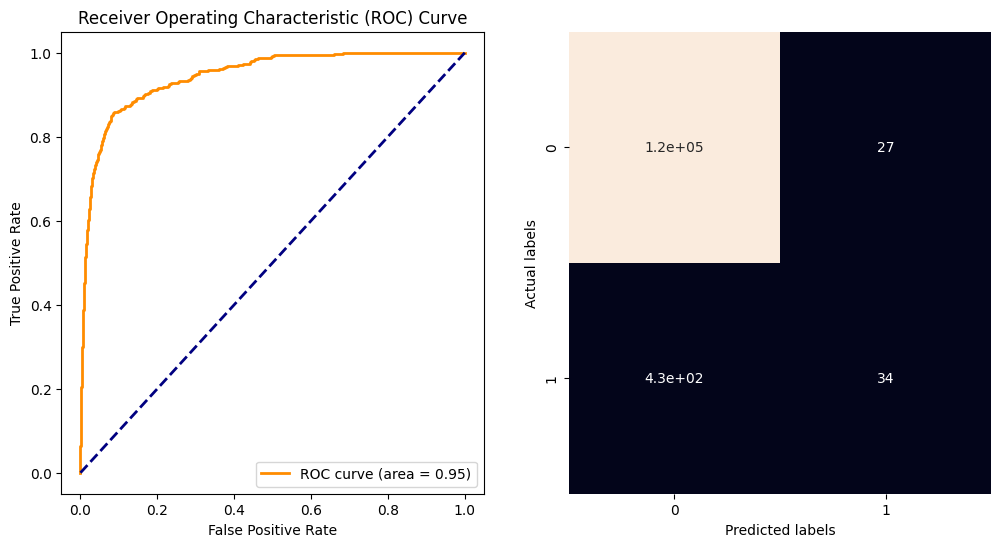

In [56]:
model_lr = LogisticRegression()

# # Define the parameter grid to search over
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
#     'solver': ['liblinear', 'saga'],  # Solver
#     'max_iter': [100, 200, 300]  # Number of iterations
# }

# # Initialize GridSearchCV with the logistic regression model, parameter grid, and desired settings
# grid_search = GridSearchCV(model_lr, param_grid, cv=5, scoring='accuracy', verbose=1)

# # Fit GridSearchCV to the PCA-transformed training data
# grid_search.fit(X_train_pca, Y_train)

# # Retrieve the best model from grid search
# best_model_lr = grid_search.best_estimator_

time_start = time.time()
model_lr, acc_lr, f1_lr, roc_auc_lr = train_model(model_lr, X_train_scaled, Y_train, X_test_scaled, Y_test)
time_taken_lr = time.time() - time_start

#GaussianNB

Accuracy:  0.9917903326642756
F1 Score:  0.9931507315333843
AUC(ROC):  0.7092663159543268

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    121100
         1.0       0.21      0.42      0.28       464

    accuracy                           0.99    121564
   macro avg       0.61      0.71      0.64    121564
weighted avg       0.99      0.99      0.99    121564



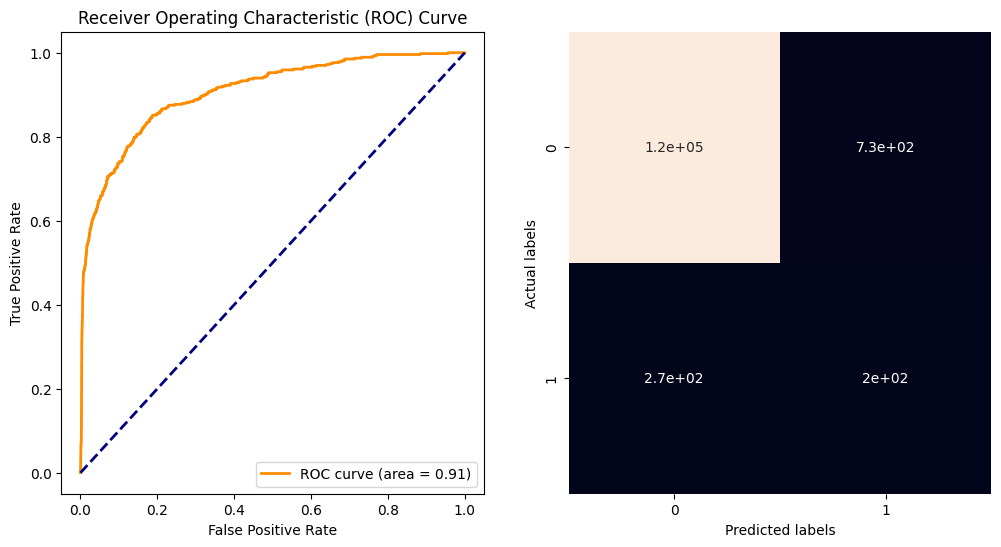

In [57]:
model_gnb = GaussianNB()
time_start = time.time()
model_gnb, acc_gnb, f1_gnb, roc_auc_gnb = train_model(model_gnb, X_train_scaled, Y_train, X_test_scaled, Y_test)
time_taken_gnb = time.time() - time_start

#Decision tree

Accuracy:  0.9952370767661479
F1 Score:  0.9953374371581211
AUC(ROC):  0.7088493764059342

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    121100
         1.0       0.39      0.42      0.40       464

    accuracy                           1.00    121564
   macro avg       0.69      0.71      0.70    121564
weighted avg       1.00      1.00      1.00    121564



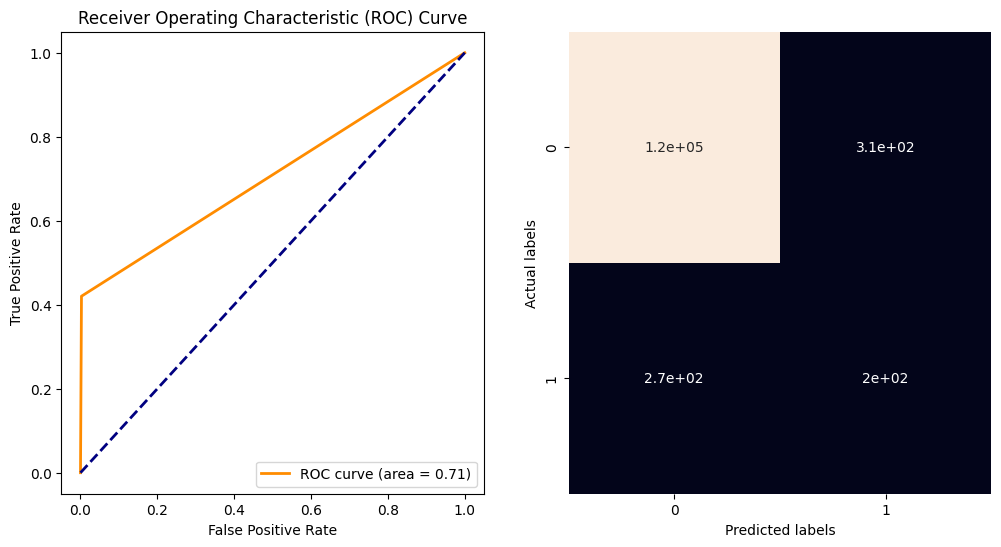

In [58]:
model_dt = DecisionTreeClassifier()
time_start = time.time()
model_dt, acc_dt, f1_dt, roc_auc_dt = train_model(model_dt, X_train_scaled, Y_train, X_test_scaled, Y_test)
time_taken_dt = time.time() - time_start

#Random Forest

Accuracy:  0.9983794544437498
F1 Score:  0.9982583683295145
AUC(ROC):  0.828506897975455

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    121100
         1.0       0.89      0.66      0.76       464

    accuracy                           1.00    121564
   macro avg       0.94      0.83      0.88    121564
weighted avg       1.00      1.00      1.00    121564



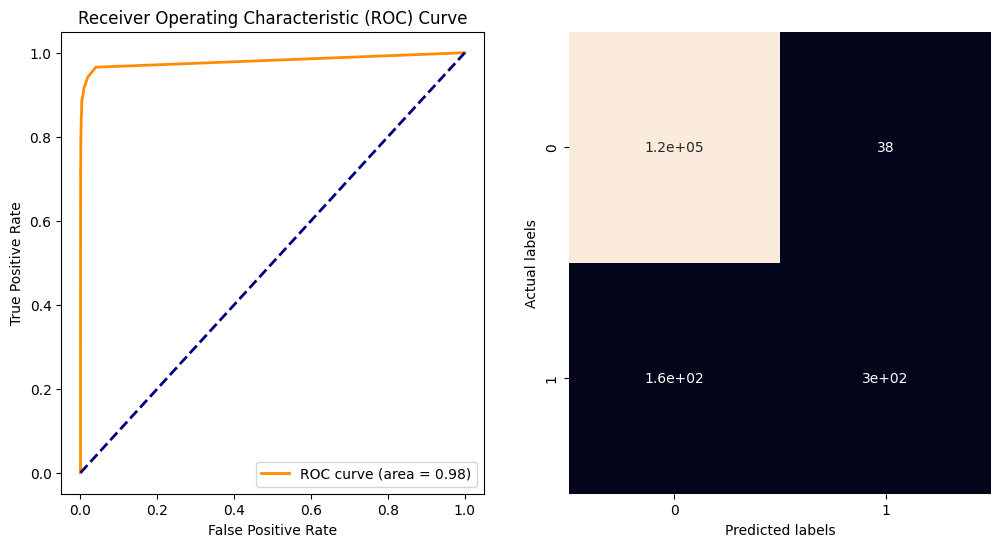

In [53]:
model_rf = RandomForestClassifier()

# # Define a simple parameter grid to explore
# param_grid = {
#     'n_estimators': [100, 200],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the tree
#     # Add more parameters here as needed
# }

# # Set up the grid search
# grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='accuracy', verbose=1)

# # Fit the grid search to the data
# # grid_search.fit(X_train_pca, Y_train)

# # Retrieve the best estimator
# best_model_rf = grid_search.best_estimator_

time_start = time.time()
model_rf, acc_rf, f1_rf, roc_auc_rf = train_model(model_rf, X_train_processed, Y_train, X_test_processed, Y_test)
time_taken_rf = time.time() - time_start

#XGB Boost

Accuracy:  0.9976061992037116
F1 Score:  0.997539719892076
AUC(ROC):  0.816310757709502

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    121100
         1.0       0.71      0.63      0.67       464

    accuracy                           1.00    121564
   macro avg       0.85      0.82      0.83    121564
weighted avg       1.00      1.00      1.00    121564



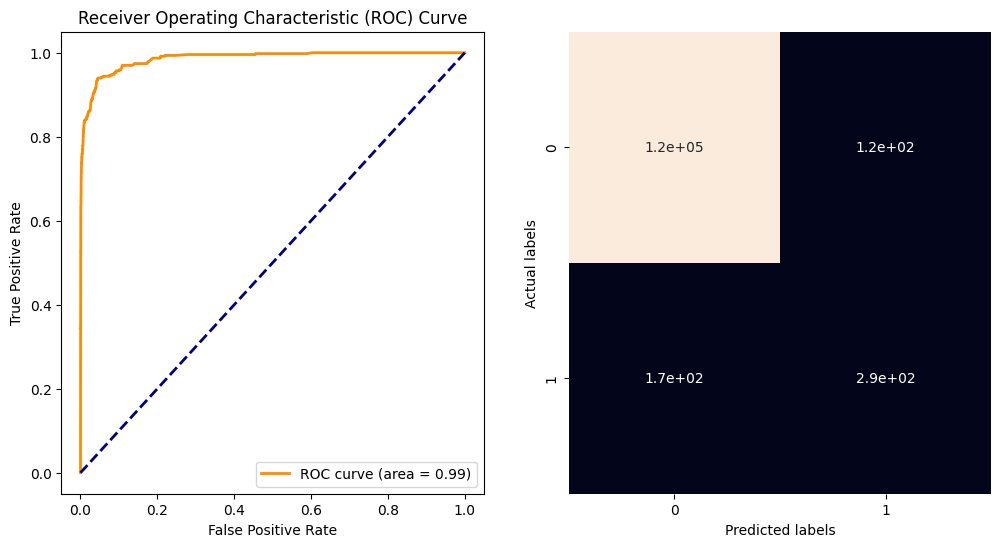

In [59]:
model_xgb = xgb.XGBRFClassifier()
time_start = time.time()
model_xgb, acc_xgb, f1_xgb, roc_auc_xgb = train_model(model_xgb, X_train_processed, Y_train, X_test_processed, Y_test)
time_taken_xgb = time.time() - time_start

#Report

In [60]:
accuracies = [acc_lr, acc_gnb, acc_dt, acc_rf, acc_xgb]
f_score = [f1_lr, f1_gnb, f1_dt, f1_rf, f1_xgb]
roc_auc = [roc_auc_lr, roc_auc_gnb, roc_auc_dt, roc_auc_rf, roc_auc_xgb]
time = [time_taken_lr, time_taken_gnb, time_taken_dt, time_taken_rf, time_taken_xgb]

final_df = pd.DataFrame({"Accuracies": accuracies, "F1 Scores": f_score, "ROC AUC": roc_auc, "Time Taken": time},
                       index = ['LogisticReg', 'GaussianNB', 'DecisionTree', 'RandomForest', 'XGB'])
final_df = final_df.round(4)
final_df

,Accuracies,F1 Scores,ROC AUC,Time Taken
LogisticReg,0.9962,0.9948,0.5365,1.9014
GaussianNB,0.9918,0.9932,0.7093,1.1180
DecisionTree,0.9952,0.9953,0.7088,23.8305
RandomForest,0.9984,0.9983,0.8285,92.4513
XGB,0.9976,0.9975,0.8163,11.8449


#Stacking

Accuracy:  0.9993254581948603
F1 Score:  0.9993056883341156
AUC(ROC):  0.9266006131963825

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    121114
         1.0       0.96      0.85      0.90       450

    accuracy                           1.00    121564
   macro avg       0.98      0.93      0.95    121564
weighted avg       1.00      1.00      1.00    121564



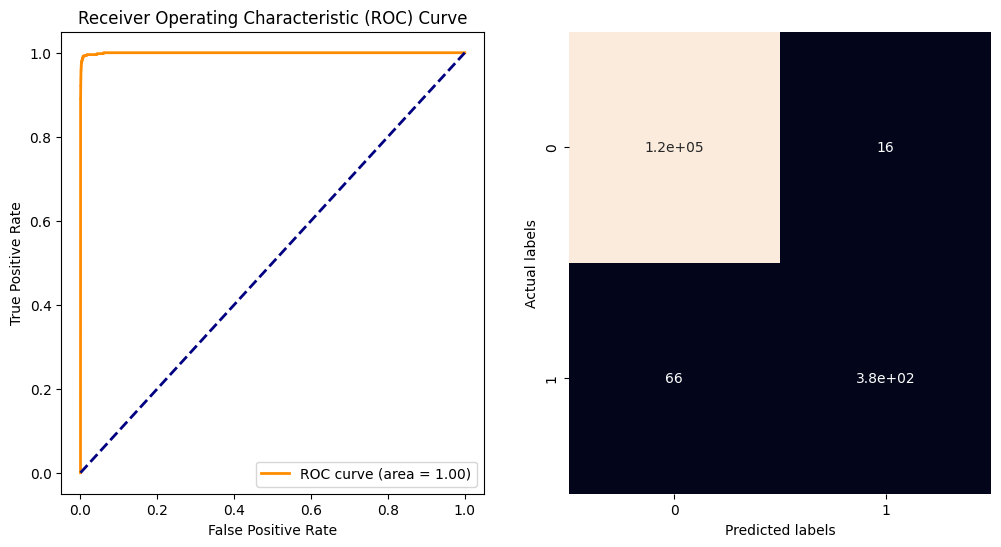

Time taken for stacking model: 402.98 seconds


In [43]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import time
# Define base models, focusing on RandomForest and XGB based on their performance and efficiency
base_models = [
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

# Define the stacking model
# Using Logistic Regression as the final estimator based on its use as a common, efficient classifier for aggregating predictions
stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
# Assuming X_train_processed, Y_train, X_test_processed, and Y_test are already defined
# Time the training process
time_start = time.time()
stack_model, acc_stack, f1_stack, roc_auc_stack = train_model(stack_model, X_train_processed, Y_train, X_test_processed, Y_test)
time_taken_stack = time.time() - time_start

print("Time taken for stacking model: {:.2f} seconds".format(time_taken_stack))

## Create the Kaggle submission

In [51]:
# X_submission = pd.read_csv("/content/drive/My Drive/Fourth CS506 Midterm/X_test.csv")
# print("testX shape is ", X_submission.shape)
# # print("testX shape is ", X_submission.head)

# X_submission_processed = X_submission._get_numeric_data().drop(columns=['is_fraud'])
# print(X_submission_processed.columns)

# # Use the trained model for predictions
# X_submission['is_fraud'] = stack_model.predict(X_submission_processed)
# X_submission['is_fraud'] = X_submission['is_fraud'].astype(int)

# # X_submission['is_fraud'] = model.predict(X_submission_processed)
# X_submission.is_fraud = X_submission.is_fraud.astype(int)
# submission = X_submission[['Id', 'is_fraud']]
# print("tafter shape is ", X_submission.shape)
# # print("tafter shape is ", X_submission.head)
# submission.to_csv("/content/drive/My Drive/Fourth CS506 Midterm/submission.csv", index=False)
# print("Final: ", submission.shape)

In [50]:

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

features_used_in_training = ['above_avg_spend', 'age', 'age_at_transaction', 'amt', 'avg_fraud_amt',
       'avg_non_fraud_amt', 'category_avg_deviation', 'city_pop',
       'cluster_merch', 'cluster_owner', 'customer_avg_amt',
       'customer_daily_freq', 'customer_fraud_rate', 'freq_bin',
       'high_risk_hour', 'high_risk_hour_grocery_pos',
       'high_risk_hour_shopping_net', 'hour_of_day', 'is_grocery_pos',
       'is_misc_net', 'is_shopping_net', 'lat', 'merch_lat',
       'merchant_fraud_history', 'trans_month', 'transaction_frequency',
       'unix_time', 'unusual_spending', 'Id']

# Load test data
X_submission = pd.read_csv("/content/drive/My Drive/Fourth CS506 Midterm/X_test.csv")

# Select the features used in training from the test data
X_submission_processed = X_submission[features_used_in_training]

# Make predictions using the trained model
X_submission['is_fraud'] = stack_model.predict(X_submission_processed)

# Submission file
submission = X_submission[['Id', 'is_fraud']]
submission.to_csv("/content/drive/My Drive/Fourth CS506 Midterm/submission.csv", index=False)

Now you can upload the `submission.csv` to kaggle